# Аналіз задач регресії та класифікації на прикладі California Housing

У цьому ноутбуці ми:
1. Завантажуємо дані та попередньо обробляємо їх:
   - Розділяємо дані на тренувальні (80%) та тестові (20%)
   - Замінюємо/видаляємо пропущені значення (якщо є)
   - Нормалізуємо числові ознаки
   - Перетворюємо категоріальні змінні у числові (якщо є)

2. Розв’язуємо задачу регресії:
   - Будуємо моделі: лінійна регресія (OLS), Random Forest, Gradient Boosting
   - Розраховуємо довірчі інтервали (95%) для лінійної моделі
   - Обчислюємо метрики: MAE, RMSE, R²

3. Використовуємо ансамблеві методи:
   - Bagging (Random Forest)
   - Boosting (Gradient Boosting)
   - Stacking (комбінація декількох моделей)
   - Оцінюємо їх результати

4. Перетворюємо регресію на класифікацію:
   - Дискретизуємо цільову змінну (Equal-width binning)
   - Навчаємо класифікатори: логістична регресія, Decision Tree, XGBoost
   - Обчислюємо метрики: Accuracy, Precision, Recall, F1-score та Confusion Matrix

5. Досліджуємо розподіл ймовірностей у класифікації:
   - Виводимо розподіл передбачуваних ймовірностей для кожного класу
   - Будуємо гістограми ймовірностей, аналізуємо впевненість моделей

6. Оптимізуємо класифікатор за допомогою GridSearchCV та порівнюємо результати з регресійним підходом.

## 1. Імпорт бібліотек та підготовка даних

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Бібліотеки для машинного навчання
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Моделі регресії
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import statsmodels.api as sm

# Моделі класифікації
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Моделі для ансамблю
from sklearn.ensemble import StackingRegressor


In [27]:
import warnings
warnings.filterwarnings("ignore")

In [5]:

# Встановлюємо стиль графіків
sns.set_theme(style='whitegrid', context='notebook')

### Завантаження даних та розділення на тренувальну та тестову вибірки

In [7]:
# Завантажуємо датасет California Housing
california = fetch_california_housing(as_frame=True)
df = california.frame

# Оглянемо дані
print("Розмір даних:", df.shape)
display(df.head())


Розмір даних: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [8]:
# Розділяємо дані: 80% тренувальні, 20% тестові
X = df.drop('MedHouseVal', axis=1)  # ознаки
y = df['MedHouseVal']               # цільова змінна

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Тренувальних зразків:", X_train.shape[0])
print("Тестових зразків:", X_test.shape[0])


Тренувальних зразків: 16512
Тестових зразків: 4128


### Попереднє опрацювання даних
- Перевірка на пропущені значення
- Стандартизація числових ознак


In [ ]:
# Перевіримо наявність пропущених значень
print("Пропущені значення у тренувальних даних:\n", X_train.isnull().sum())

# Оскільки у цьому датасеті немає пропущених значень, переходимо до стандартизації
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                              columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                             columns=X_test.columns, index=X_test.index)

Пропущені значення у тренувальних даних:
 MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64


## 2. Розв’язання задачі ймовірнісної регресії


### 2.1 Побудова регресійних моделей

Ми використовуємо:
- Лінійну регресію (за допомогою scikit-learn та statsmodels для довірчих інтервалів)
- Random Forest Regressor
- Gradient Boosting Regressor


In [ ]:

# Лінійна регресія (sklearn)
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

# Розрахунок метрик для лінійної регресії
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
print("Лінійна регресія - MAE: {:.3f}, RMSE: {:.3f}, R²: {:.3f}".format(mae_lr, rmse_lr, r2_lr))


# Для отримання довірчих інтервалів використаємо OLS з statsmodels
X_train_sm = sm.add_constant(X_train_scaled)
X_test_sm = sm.add_constant(X_test_scaled)
ols_model = sm.OLS(y_train, X_train_sm).fit()
predictions_sm = ols_model.get_prediction(X_test_sm)
pred_summary = predictions_sm.summary_frame(alpha=0.05)  # 95% інтервал
display(pred_summary.head())



Лінійна регресія - MAE: 0.533, RMSE: 0.746, R²: 0.576


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
20046,0.719123,0.010630,0.698288,0.739958,-0.692058,2.130303
3024,1.764017,0.008072,1.748195,1.779838,0.352901,3.175132
15663,2.709659,0.017551,2.675256,2.744061,1.298213,4.121105
20484,2.838926,0.010153,2.819024,2.858827,1.427759,4.250093
9814,2.604657,0.014300,2.576628,2.632687,1.193352,4.015962



### 2.2 Додавання ймовірнісних меж (довірчих інтервалів)

Для лінійної моделі ми використовуємо метод get_prediction з statsmodels, 
що повертає нижню та верхню межу довірчого інтервалу для кожного прогнозу.


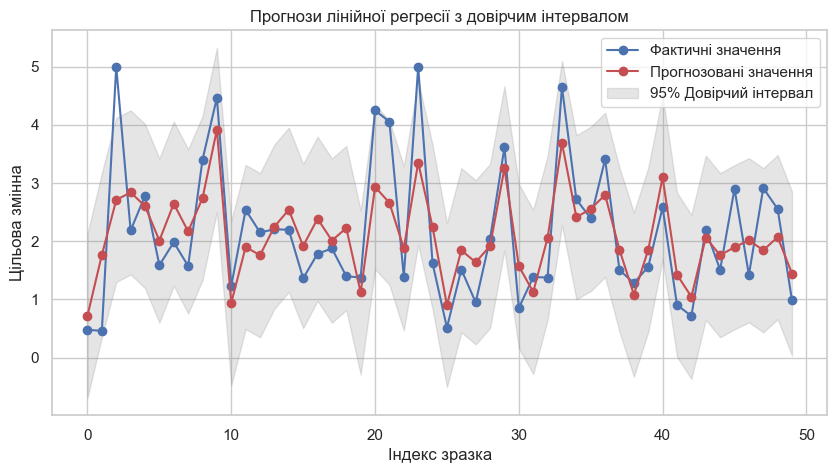

In [15]:
# Візуалізація прогнозів лінійної регресії з довірчими інтервалами для перших 50 зразків
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:50], 'bo-', label='Фактичні значення')
plt.plot(y_pred_lr[:50], 'ro-', label='Прогнозовані значення')
plt.fill_between(np.arange(50), 
                 pred_summary['obs_ci_lower'][:50], 
                 pred_summary['obs_ci_upper'][:50], 
                 color='gray', alpha=0.2, label='95% Довірчий інтервал')
plt.legend()
plt.xlabel('Індекс зразка')
plt.ylabel('Цільова змінна')
plt.title('Прогнози лінійної регресії з довірчим інтервалом')
plt.show()


Gradient Boosting - MAE: 0.372, RMSE: 0.542, R²: 0.776
    Actual  Predicted  Lower Bound  Upper Bound
0  0.47700   0.505188     0.416342     2.507010
1  0.45800   1.093346     0.590814     3.153212
2  5.00001   4.245710     0.973153     5.496914
3  2.18600   2.545174     1.665012     3.772843
4  2.78000   2.279103     1.018777     3.902203
5  1.58700   1.723910     1.364862     3.653442
6  1.98200   2.337197     1.442895     3.730088
7  1.57500   1.719774     1.124949     2.889842
8  3.40000   3.099624     1.330586     5.099960
9  4.46600   4.304469     1.920822     5.000010


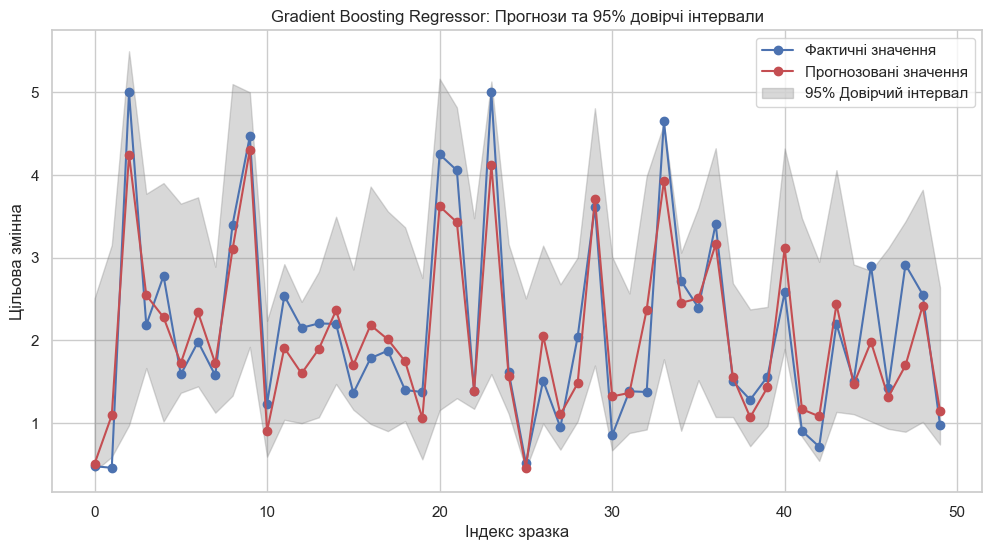

In [ ]:
# Gradient Boosting Regressor (базова модель)
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)
print("Gradient Boosting - MAE: {:.3f}, RMSE: {:.3f}, R²: {:.3f}".format(mae_gb, rmse_gb, r2_gb))
# Обчислення довірчих інтервалів за допомогою квантильного градієнтного бустингу
# Навчаємо дві додаткові моделі для нижньої та верхньої меж (95% довірчий інтервал)

# Модель для нижньої межі (2.5-й процентиль)
gb_lower = GradientBoostingRegressor(loss='quantile', alpha=0.025, n_estimators=100, learning_rate=0.1, random_state=42)
gb_lower.fit(X_train_scaled, y_train)
y_pred_lower = gb_lower.predict(X_test_scaled)

# Модель для верхньої межі (97.5-й процентиль)
gb_upper = GradientBoostingRegressor(loss='quantile', alpha=0.975, n_estimators=100, learning_rate=0.1, random_state=42)
gb_upper.fit(X_train_scaled, y_train)
y_pred_upper = gb_upper.predict(X_test_scaled)

# Виведемо декілька прикладів прогнозів з довірчими інтервалами
results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_gb,
    'Lower Bound': y_pred_lower,
    'Upper Bound': y_pred_upper
})
print(results.head(10))
# Візуалізація прогнозів та довірчих інтервалів для перших 50 зразків
plt.figure(figsize=(12,6))
indices = np.arange(50)
plt.plot(indices, y_test.values[:50], 'bo-', label='Фактичні значення')
plt.plot(indices, y_pred_gb[:50], 'ro-', label='Прогнозовані значення')
plt.fill_between(indices, y_pred_lower[:50], y_pred_upper[:50], color='gray', alpha=0.3, label='95% Довірчий інтервал')
plt.xlabel('Індекс зразка')
plt.ylabel('Цільова змінна')
plt.title('Gradient Boosting Regressor: Прогнози та 95% довірчі інтервали')
plt.legend()
plt.show()


Random Forest - MAE: 0.327, RMSE: 0.505, R²: 0.805
    Actual  Predicted  Min Prediction  Max Prediction
0  0.47700   0.509500           0.414         2.37500
1  0.45800   0.741610           0.266         1.84000
2  5.00001   4.923257           3.450         5.00001
3  2.18600   2.529610           1.538         3.46100
4  2.78000   2.273690           0.965         3.03400
5  1.58700   1.645060           0.832         3.25200
6  1.98200   2.376610           1.776         4.30900
7  1.57500   1.670270           0.961         2.05200
8  3.40000   2.772971           1.468         5.00001
9  4.46600   4.913459           2.637         5.00001


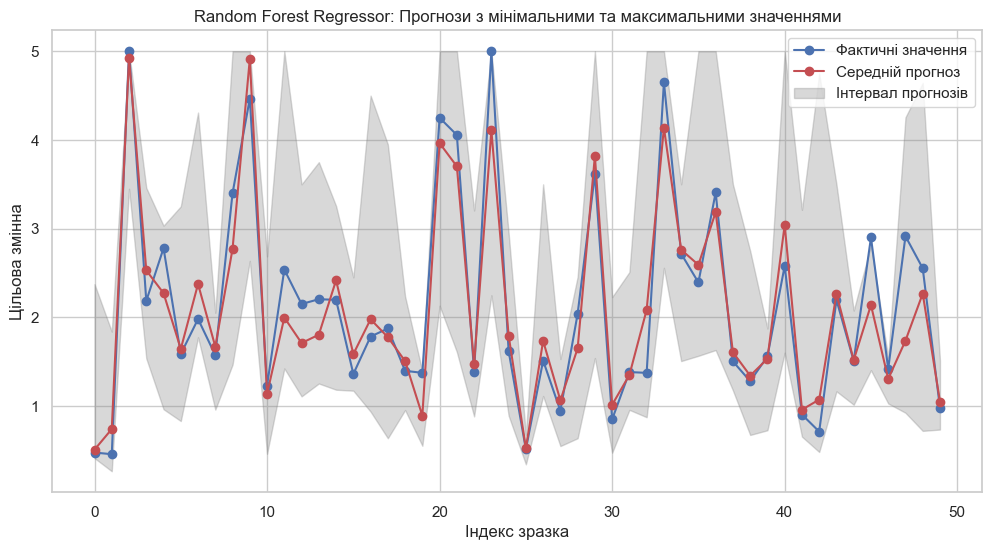

In [ ]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest - MAE: {:.3f}, RMSE: {:.3f}, R²: {:.3f}".format(mae_rf, rmse_rf, r2_rf))

# ---------------------------------------------------------
# Отримуємо прогнози окремих дерев для кожного зразка
# rf_model.estimators_ містить окремі дерева
tree_preds = np.array([tree.predict(X_test_scaled) for tree in rf_model.estimators_]).T

# Для кожного зразка знаходимо мінімальне та максимальне значення прогнозів
y_pred_min = tree_preds.min(axis=1)
y_pred_max = tree_preds.max(axis=1)

# Створимо DataFrame для порівняння: фактичні значення, середній прогноз, нижня та верхня межа прогнозу
results_rf = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_rf,
    'Min Prediction': y_pred_min,
    'Max Prediction': y_pred_max
})
print(results_rf.head(10))

# ---------------------------------------------------------
# Візуалізація прогнозів із мінімальними та максимальними значеннями для перших 50 зразків
plt.figure(figsize=(12,6))
indices = np.arange(50)
plt.plot(indices, y_test.values[:50], 'bo-', label='Фактичні значення')
plt.plot(indices, y_pred_rf[:50], 'ro-', label='Середній прогноз')
plt.fill_between(indices, y_pred_min[:50], y_pred_max[:50], color='gray', alpha=0.3, label='Інтервал прогнозів')
plt.xlabel('Індекс зразка')
plt.ylabel('Цільова змінна')
plt.title('Random Forest Regressor: Прогнози з мінімальними та максимальними значеннями')
plt.legend()
plt.show()


## 3. Перехід від регресії до класифікації

Ми перетворимо регресійне завдання у класифікаційне, розбивши цільову змінну на класи за допомогою equal-width binning.

In [17]:
# Використовуємо KBinsDiscretizer для рівномірного розбиття (наприклад, на 4 класи)
n_bins = 4
kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
y_train_class = kbd.fit_transform(y_train.values.reshape(-1, 1)).astype(int).ravel()
y_test_class = kbd.transform(y_test.values.reshape(-1, 1)).astype(int).ravel()

print("Розподіл класів у тренувальних даних:\n", pd.Series(y_train_class).value_counts())


Розподіл класів у тренувальних даних:
 1    7004
0    5097
2    2773
3    1638
Name: count, dtype: int64


c:\Users\narus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [19]:

# Побудова класифікаційних моделей
# Логістична регресія
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train_class)
y_pred_logreg = logreg.predict(X_test_scaled)

# Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train_scaled, y_train_class)
y_pred_dtc = dtc.predict(X_test_scaled)

# XGBoost Classifier
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train_scaled, y_train_class)
y_pred_xgb = xgb_clf.predict(X_test_scaled)

In [20]:

# Функція для оцінки якості класифікації
def print_classification_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"{model_name} - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1-score: {f1:.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))


print_classification_metrics(y_test_class, y_pred_logreg, "Логістична регресія")
print_classification_metrics(y_test_class, y_pred_dtc, "Decision Tree")
print_classification_metrics(y_test_class, y_pred_xgb, "XGBoost")

Логістична регресія - Accuracy: 0.683, Precision: 0.680, Recall: 0.683, F1-score: 0.674
Confusion Matrix:
[[ 937  328    3    2]
 [ 227 1429  120   11]
 [  18  348  236   68]
 [   8   88   89  216]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.74      0.76      1270
           1       0.65      0.80      0.72      1787
           2       0.53      0.35      0.42       670
           3       0.73      0.54      0.62       401

    accuracy                           0.68      4128
   macro avg       0.67      0.61      0.63      4128
weighted avg       0.68      0.68      0.67      4128

Decision Tree - Accuracy: 0.689, Precision: 0.690, Recall: 0.689, F1-score: 0.690
Confusion Matrix:
[[1002  247   15    6]
 [ 258 1262  210   57]
 [  25  204  350   91]
 [   8   42  119  232]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.79      0.78      1270
           1  

### 3.1 Повторення з іншим кроком дискретизації

Наприклад, спробуємо дискретизацію з 6 класами.

In [21]:

n_bins_alt = 6
kbd_alt = KBinsDiscretizer(n_bins=n_bins_alt, encode='ordinal', strategy='uniform')
y_train_class_alt = kbd_alt.fit_transform(y_train.values.reshape(-1, 1)).astype(int).ravel()
y_test_class_alt = kbd_alt.transform(y_test.values.reshape(-1, 1)).astype(int).ravel()

print("Розподіл класів (6 класів) у тренувальних даних:\n", pd.Series(y_train_class_alt).value_counts())

# Перенавчання моделей на нових класах
logreg_alt = LogisticRegression(max_iter=1000, random_state=42)
logreg_alt.fit(X_train_scaled, y_train_class_alt)
y_pred_logreg_alt = logreg_alt.predict(X_test_scaled)
print_classification_metrics(y_test_class_alt, y_pred_logreg_alt, "Логістична регресія (6 класів)")


c:\Users\narus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


Розподіл класів (6 класів) у тренувальних даних:
 1    5464
2    4043
0    2594
3    2062
5    1249
4    1100
Name: count, dtype: int64
Логістична регресія (6 класів) - Accuracy: 0.548, Precision: 0.523, Recall: 0.548, F1-score: 0.527
Confusion Matrix:
[[385 255   9   0   1   0]
 [147 982 237  10   1   4]
 [ 13 350 583  56  11  13]
 [  4  62 254 130  14  28]
 [  1  17  91  91   6  73]
 [  3  12  53  49   8 175]]

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.59      0.64       650
           1       0.59      0.71      0.64      1381
           2       0.48      0.57      0.52      1026
           3       0.39      0.26      0.31       492
           4       0.15      0.02      0.04       279
           5       0.60      0.58      0.59       300

    accuracy                           0.55      4128
   macro avg       0.48      0.46      0.46      4128
weighted avg       0.52      0.55      0.53      4128



## 5. Дослідження розподілу ймовірностей у класифікації

Побудуємо гістограми ймовірностей для моделі Random Forest Classifier (як приклад).


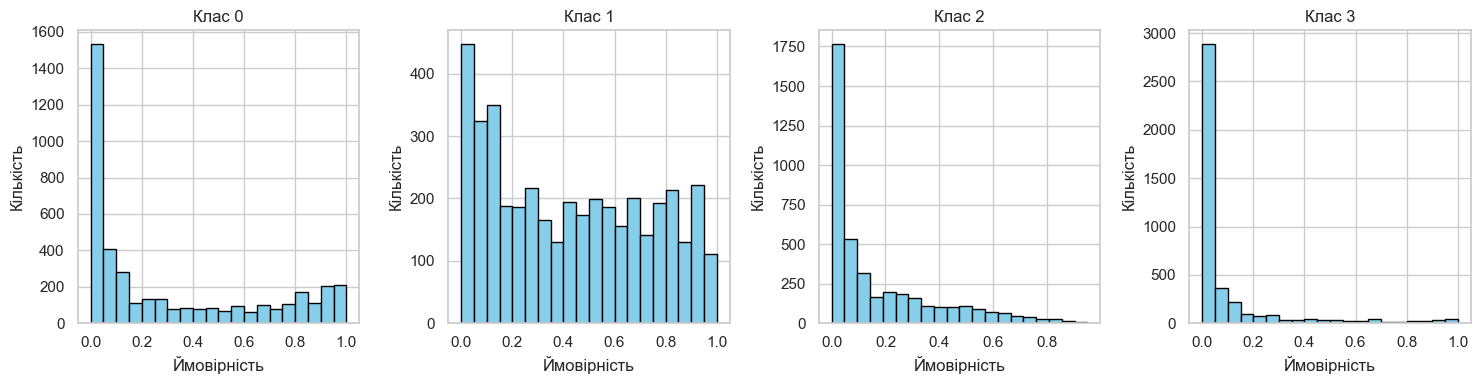

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Навчаємо Random Forest для класифікації (на попередньо отриманих класах з 4 класів)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_scaled, y_train_class)
y_proba_rf = rf_clf.predict_proba(X_test_scaled)

# Для кожного класу побудуємо гістограму передбачуваних ймовірностей
plt.figure(figsize=(15, 4))
for i in range(n_bins):
    plt.subplot(1, n_bins, i+1)
    plt.hist(y_proba_rf[:, i], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Клас {i}")
    plt.xlabel("Ймовірність")
    plt.ylabel("Кількість")
plt.tight_layout()
plt.show()


# Аналіз розподілу ймовірностей може показати, як модель впевнено/невпевнено класифікує зразки.
# При overfitting часто спостерігається надмірна впевненість (ймовірності близькі до 0 або 1),
# тоді як при underfitting розподіл буде більш рівномірним.


## 6. Оптимізація класифікатора та порівняння з регресією

Оптимізуємо гіперпараметри класифікаційної моделі (наприклад, Decision Tree) за допомогою GridSearchCV.


In [23]:
# Підбираємо параметри для Decision Tree
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_class)
print("Найкращі параметри для Decision Tree:", grid_search.best_params_)

# Оцінка оптимізованої моделі
dtc_opt = grid_search.best_estimator_
y_pred_dtc_opt = dtc_opt.predict(X_test_scaled)
print_classification_metrics(y_test_class, y_pred_dtc_opt, "Оптимізований Decision Tree")


Найкращі параметри для Decision Tree: {'max_depth': None, 'min_samples_split': 10}
Оптимізований Decision Tree - Accuracy: 0.689, Precision: 0.689, Recall: 0.689, F1-score: 0.688
Confusion Matrix:
[[1032  222   15    1]
 [ 265 1260  225   37]
 [  21  230  326   93]
 [   5   39  132  225]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.80      1270
           1       0.72      0.71      0.71      1787
           2       0.47      0.49      0.48       670
           3       0.63      0.56      0.59       401

    accuracy                           0.69      4128
   macro avg       0.65      0.64      0.64      4128
weighted avg       0.69      0.69      0.69      4128



In [ ]:

# Порівняння регресії та класифікації
print("Порівняння:")
print("Регресійна задача регресії (наприклад, Random Forest): RMSE = {:.3f}".format(rmse_rf))
print("Класифікаційна задача (оптимізований Decision Tree): Accuracy = {:.3f}".format(accuracy_score(y_test_class, y_pred_dtc_opt)))


# Висновки:
# - Порівнюючи результати, можна визначити, чи дає дискретизація цільової змінної (класифікація)
#   кращі результати, чи ж регресія є більш інформативною.
# - Розподіл ймовірностей показав, як модель впевнено робить прогнози.
# - Ансамблеві підходи (Stacking, Random Forest, Gradient Boosting) здатні покращити результати за відповідними метриками.



Порівняння:
Регресійна задача регресії (наприклад, Random Forest): RMSE = 0.505
Класифікаційна задача (оптимізований Decision Tree): Accuracy = 0.689


In [32]:
# Порівняння регресії та класифікації

print("=== Порівняння ===")
print("Регресійна задача (Random Forest):")
print("  RMSE = {:.3f}".format(rmse_rf))
print("  MAE  = {:.3f}".format(mae_rf))
print("")
print("Класифікаційна задача (Оптимізований Decision Tree):")
acc_clf = accuracy_score(y_test_class, y_pred_dtc_opt)
print("  Accuracy = {:.3f}".format(acc_clf))

# Обчислюємо ширину класу (w) та розмах цільової змінної (R)
# Для дискретизації використовувалось n_bins = 4
n_bins = 4
y_min, y_max = y_test.min(), y_test.max()
R = y_max - y_min          # розмах цільової змінної
w = R / n_bins             # ширина кожного класу

# 1. Перетворення MAE регресії у точність класифікації:
# Формула: accuracy ≈ 1 - (MAE / w)
acc_from_mae = 1 - (mae_rf / w)

# 2. Перетворення точності класифікації у MAE:
# Формула: MAE ≈ (1 - accuracy)*R + (w / 2)
mae_from_acc = (1 - acc_clf) * R + (w / 2)

print("\n=== Перетворення за формулами ===")
print("З MAE регресії ({:.3f}) отримуємо приблизну точність: {:.3f}".format(mae_rf, acc_from_mae))
print("   (Формула: accuracy ≈ 1 - MAE/w, де w = {:.2f})".format(w))
print("")
print("З точності класифікації ({:.3f}) отримуємо приблизну MAE: {:.3f}".format(acc_clf, mae_from_acc))
print("   (Формула: MAE ≈ (1 - accuracy)*R + w/2, де R = {:.2f}, w = {:.2f})".format(R, w))


=== Порівняння ===
Регресійна задача (Random Forest):
  RMSE = 0.505
  MAE  = 0.327

Класифікаційна задача (Оптимізований Decision Tree):
  Accuracy = 0.689

=== Перетворення за формулами ===
З MAE регресії (0.327) отримуємо приблизну точність: 0.730
   (Формула: accuracy ≈ 1 - MAE/w, де w = 1.21)

З точності класифікації (0.689) отримуємо приблизну MAE: 2.116
   (Формула: MAE ≈ (1 - accuracy)*R + w/2, де R = 4.85, w = 1.21)


### ----- Дискретизація прогнозів регресії для оцінки точності -----


Точність дискретизованих прогнозів регресії = 0.7628391472868217
MAE для регресії після заміни дискретизованих прогнозів середніми значеннями класів = 0.4314274120392347


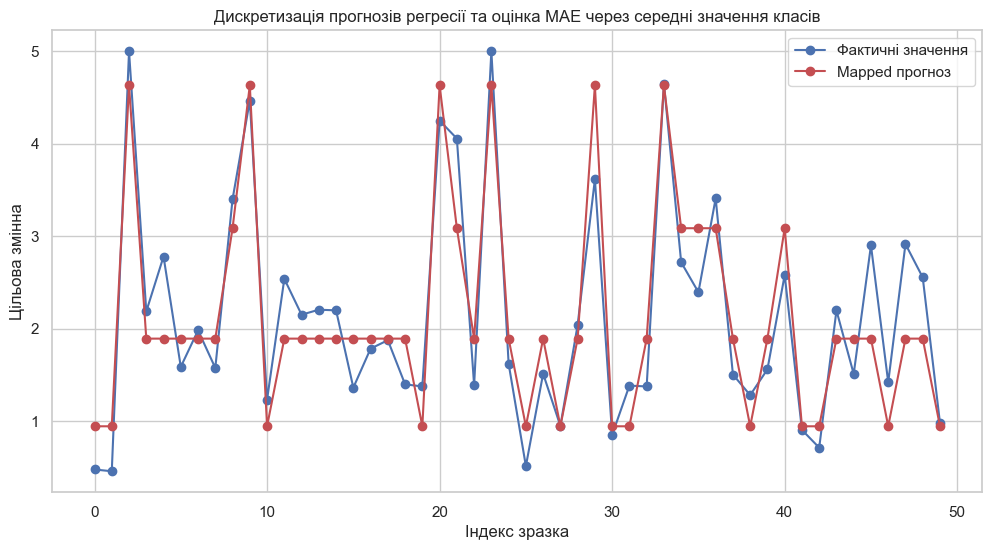

In [33]:

# Використовуємо KBinsDiscretizer, який застосовувався для формування класів (наприклад, n_bins = 4)
# Дискретизуємо регресійні прогнозування з Random Forest
reg_pred_class = kbd.transform(y_pred_rf.reshape(-1, 1)).astype(int).ravel()

# Обчислюємо точність дискретизованих прогнозів порівняно з фактичними класами
accuracy_reg_pred = accuracy_score(y_test_class, reg_pred_class)
print("Точність дискретизованих прогнозів регресії =", accuracy_reg_pred)

# ----- Оцінка MAE через середні значення класів -----

# Обчислюємо середнє значення цільової змінної для кожного класу (на тренувальних даних)
# y_train_class вже отриманий раніше при дискретизації y_train
class_means = {}
for cls in range(n_bins):
    # Якщо у класі є спостереження, обчислюємо середнє; інакше використовуємо середину інтервалу
    cls_vals = y_train[y_train_class == cls]
    if len(cls_vals) > 0:
        class_means[cls] = cls_vals.mean()
    else:
        # Визначаємо середину інтервалу для цього класу
        bin_edges = kbd.bin_edges_[0]
        class_means[cls] = (bin_edges[cls] + bin_edges[cls+1]) / 2

# Замапуємо дискретизовані прогнозування у середні значення відповідних класів
mapped_reg_pred = np.array([class_means[cls] for cls in reg_pred_class])

# Обчислюємо MAE між замапованими прогнозами та фактичними значеннями
mae_mapped = np.mean(np.abs(y_test.values - mapped_reg_pred))
print("MAE для регресії після заміни дискретизованих прогнозів середніми значеннями класів =", mae_mapped)

# Візуалізація: порівняння фактичних значень та "mapped" прогнозів для перших 50 зразків
plt.figure(figsize=(12,6))
indices = np.arange(50)
plt.plot(indices, y_test.values[:50], 'bo-', label='Фактичні значення')
plt.plot(indices, mapped_reg_pred[:50], 'ro-', label='Mapped прогноз')
plt.xlabel('Індекс зразка')
plt.ylabel('Цільова змінна')
plt.title('Дискретизація прогнозів регресії та оцінка MAE через середні значення класів')
plt.legend()
plt.show()
